# Data split for the 4-fold CV for Aspect ratio

---

This notebook can be used to generate data splits for the screening data to allow for parallel computing of the screens.

---

## 0. Environmental setup

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedGroupKFold, GroupShuffleSplit
import os
from imblearn.under_sampling import RandomUnderSampler
from tqdm import tqdm
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt

import matplotlib as mpl

mpl.rcParams["figure.dpi"] = 600

In [2]:
def get_data_splits_for_label(
    data,
    label_col,
    target_list,
    n_folds,
    group_col,
    random_state=1234,
    val_size=0.2,
    sample_limit=None,
):

    # Subsample the data
    label_data = data.loc[data.loc[:, label_col].isin(target_list), :]
    if "EMPTY" in target_list:
        idc = np.array(list(range(len(label_data)))).reshape(-1, 1)
        labels = label_data.loc[:, label_col]
        sample_count_dict = dict(Counter(labels))
        sample_count_dict["EMPTY"] = 0
        if sample_limit is not None:
            for k, v in sample_count_dict.items():
                sample_count_dict[k] = min(v, sample_limit)
        sample_count_dict["EMPTY"] = np.max(list(sample_count_dict.values()))
        print(sample_count_dict)
        idc, _ = RandomUnderSampler(
            sampling_strategy=sample_count_dict, random_state=random_state
        ).fit_resample(idc, labels)
        label_data = label_data.iloc[idc.flatten(), :]

    # Split in folds
    features = np.array(list(range(len(label_data)))).reshape(-1, 1)
    labels = np.array(label_data.loc[:, label_col])
    groups = np.array(label_data.loc[:, group_col])

    fold_data = {"train": [], "val": [], "test": []}
    group_kfold = StratifiedGroupKFold(n_splits=n_folds)
    for train_index, test_index in group_kfold.split(features, labels, groups=groups):

        train_val_fold_data = label_data.iloc[train_index]
        train_val_fold_labels = labels[train_index]
        train_val_fold_groups = groups[train_index]

        train_index, val_index = next(
            StratifiedGroupKFold(n_splits=int(1.0 / val_size)).split(
                train_val_fold_data, train_val_fold_labels, groups=train_val_fold_groups
            )
        )
        train_fold_data = train_val_fold_data.iloc[train_index]
        val_fold_data = train_val_fold_data.iloc[val_index]

        test_fold_data = label_data.iloc[test_index]

        fold_data["train"].append(train_fold_data)
        fold_data["val"].append(val_fold_data)
        fold_data["test"].append(test_fold_data)

    return fold_data

---
## 1. Read in data

To start we will read in the whole metadata set.

In [3]:
md = pd.read_csv(
    "../../../data/experiments/rohban/images/preprocessing/full_pipeline/padded_nuclei_metadata.csv.gz",
    index_col=0,
)
md.head()

,plate,well,image_file,gene_id,gene_symbol,is_landmark,allele,expr_vec,toxicity,ie_blast,...,minor_axis_length,major_axis_length,aspect_ratio,aspect_ratio_cluster,nuclei_count_image,slide_image_name,aspect_ratio_cluster_ratio,centroid_0,centroid_1,allele_symbol
0,41744,k21,taoe005-u2os-72h-cp-a-au00044859_k21_s7_w10efe...,1977.0,EIF4E,0.0,WT.2,pLX304,NaN,0.91,...,15.474579,35.755476,0.432789,1,53,taoe005-u2os-72h-cp-a-au00044859_k21_s7_w10efe...,0.528302,17.675294,19.835294,EIF4E_WT.2
1,41744,k21,taoe005-u2os-72h-cp-a-au00044859_k21_s7_w10efe...,1977.0,EIF4E,0.0,WT.2,pLX304,NaN,0.91,...,16.074259,48.342010,0.332511,1,53,taoe005-u2os-72h-cp-a-au00044859_k21_s7_w10efe...,0.528302,28.882645,273.150413,EIF4E_WT.2
2,41744,k21,taoe005-u2os-72h-cp-a-au00044859_k21_s7_w10efe...,1977.0,EIF4E,0.0,WT.2,pLX304,NaN,0.91,...,24.256958,35.030138,0.692460,0,53,taoe005-u2os-72h-cp-a-au00044859_k21_s7_w10efe...,0.528302,149.476762,1002.848576,EIF4E_WT.2
3,41744,k21,taoe005-u2os-72h-cp-a-au00044859_k21_s7_w10efe...,1977.0,EIF4E,0.0,WT.2,pLX304,NaN,0.91,...,27.689881,51.502812,0.537638,1,53,taoe005-u2os-72h-cp-a-au00044859_k21_s7_w10efe...,0.528302,250.939748,108.973921,EIF4E_WT.2
4,41744,k21,taoe005-u2os-72h-cp-a-au00044859_k21_s7_w10efe...,1977.0,EIF4E,0.0,WT.2,pLX304,NaN,0.91,...,26.587002,32.592086,0.815750,0,53,taoe005-u2os-72h-cp-a-au00044859_k21_s7_w10efe...,0.528302,252.834328,913.795522,EIF4E_WT.2


In [4]:
nmco_feats = pd.read_csv(
    "../../../data/experiments/rohban/images/preprocessing/full_pipeline/nuclei_ncmo_features.csv.gz",
    index_col=0,
)

In [5]:
spec_results = pd.read_csv(
    "../../../../image2reg/data/experiments/rohban/images/screen/nuclei_region/specificity_screen_results_cv.csv",
    index_col=0,
)
spec_results = spec_results.loc[spec_results["selected"]]
spec_orf_targets = set(spec_results.index)

In [6]:
nmco_feats = nmco_feats.loc[
    nmco_feats.gene_symbol.isin(spec_orf_targets.union({"EMPTY"}))
]
nmco_feats = nmco_feats.loc[nmco_feats.image_file.isin(list(md.image_file))]

Text(0.5, 1.0, 'Number of nuclei remaining when filtering based on the mean intensity (median $\\pm \\alpha$ IQR)')

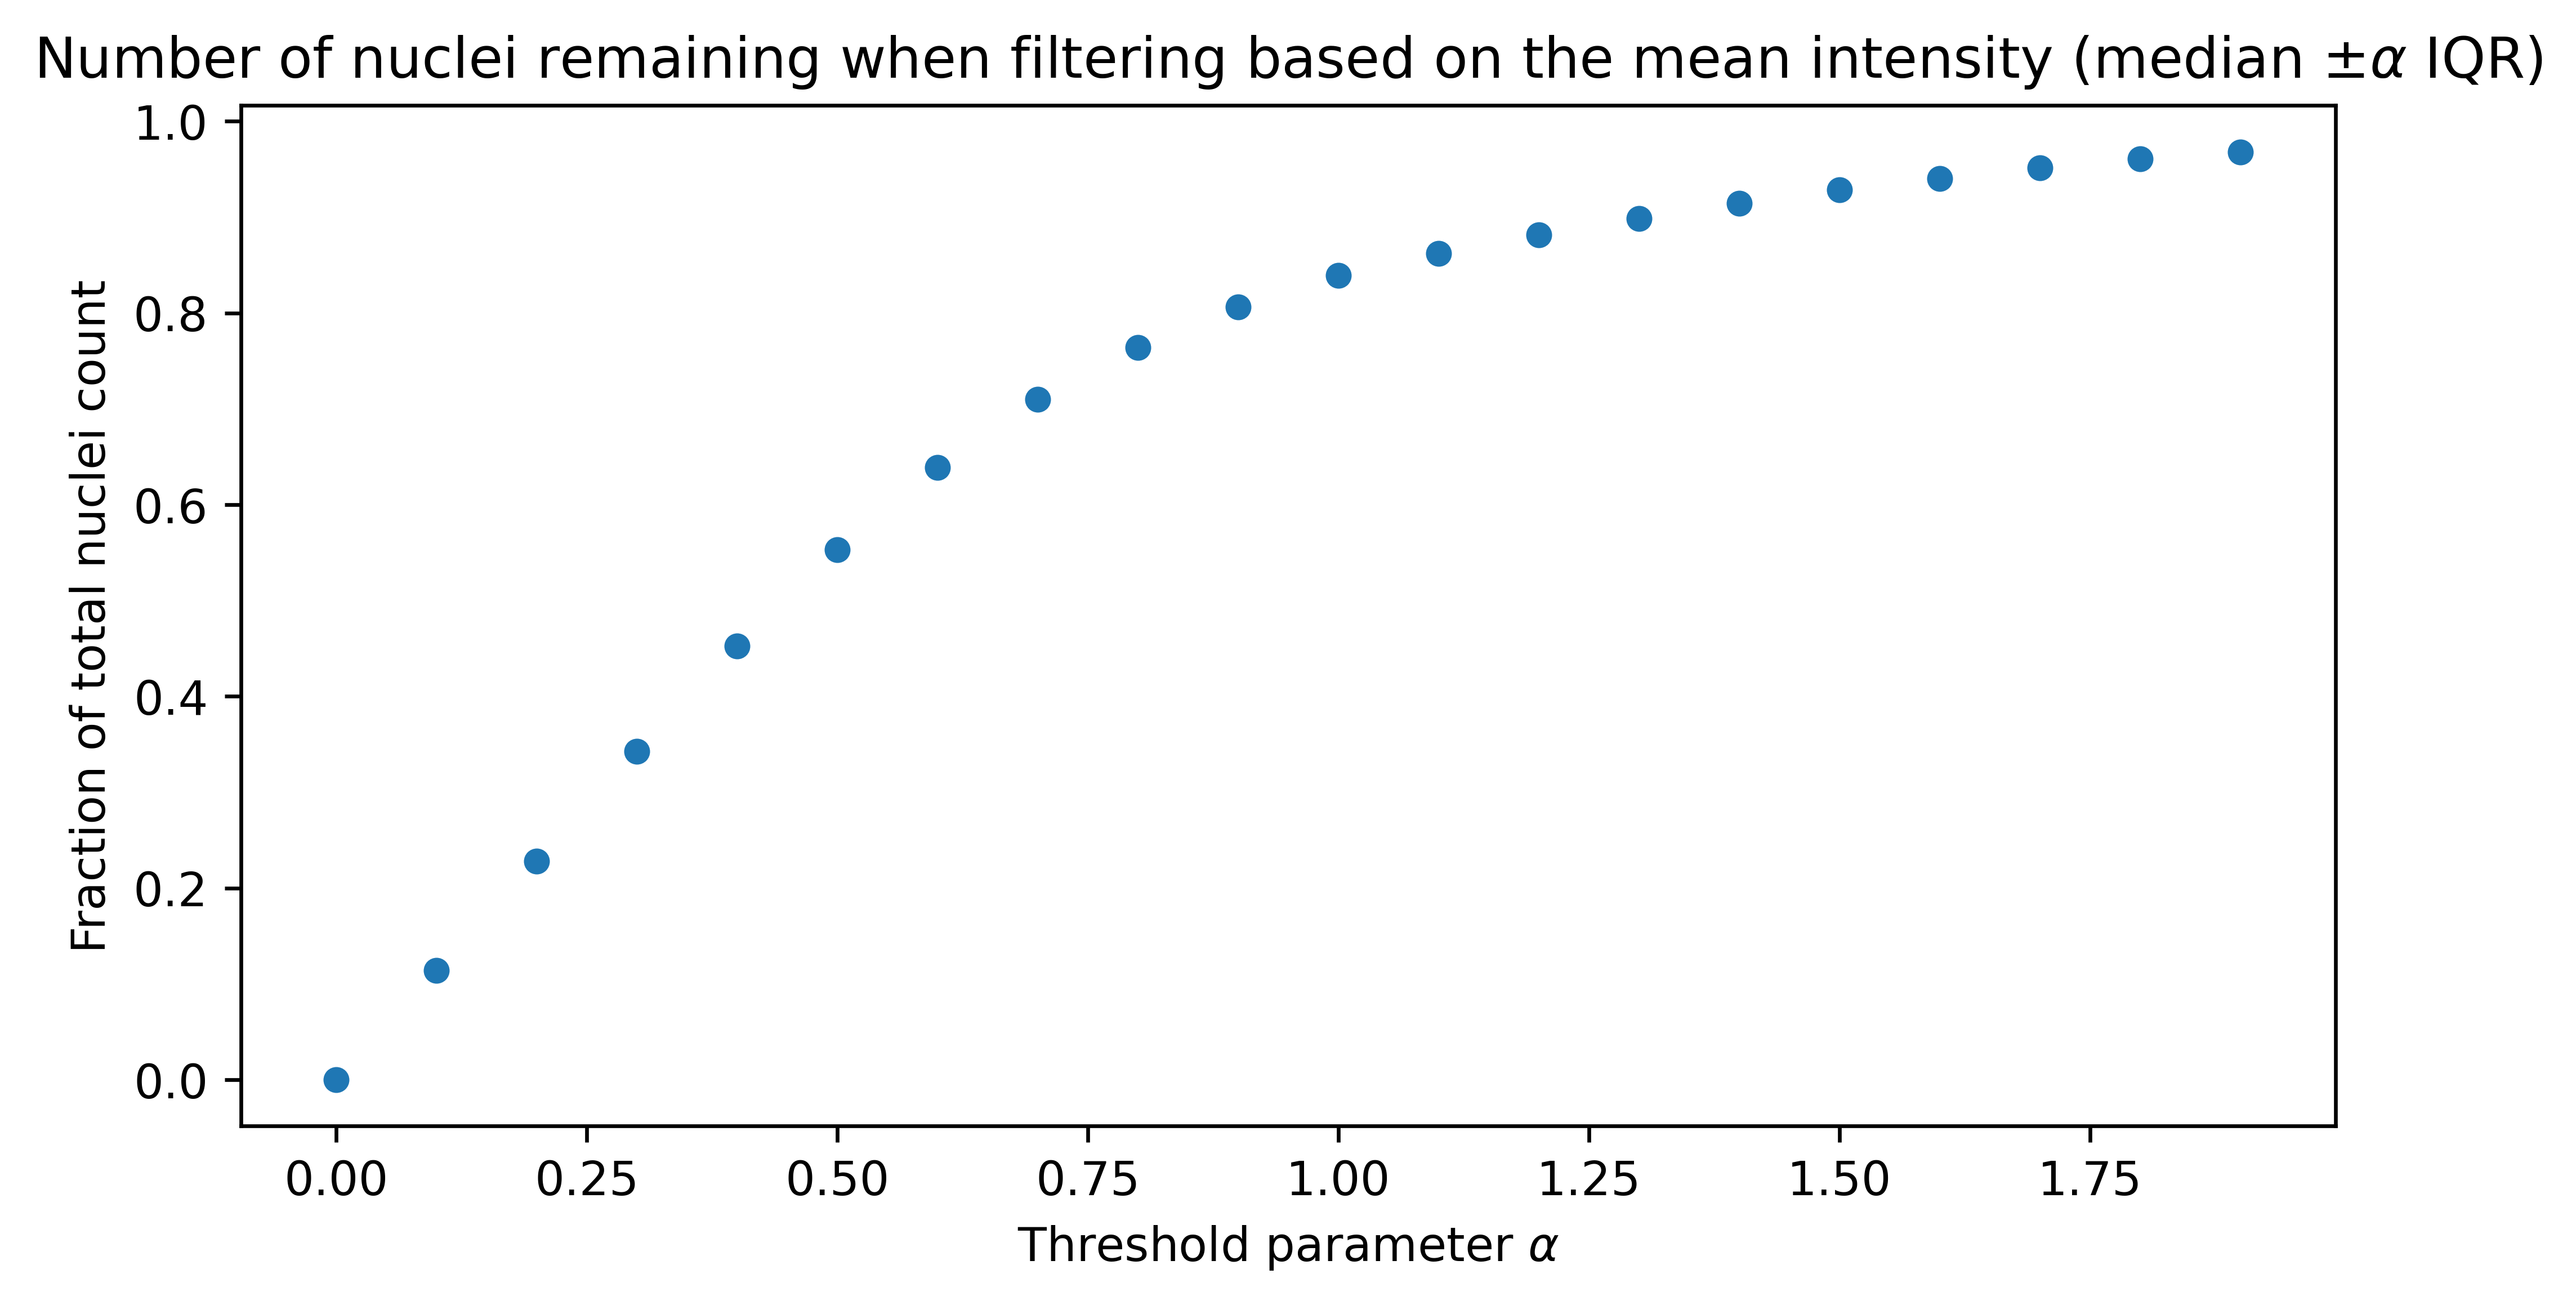

In [7]:
int_median = np.median(nmco_feats.int_mean)
int_iqr = np.quantile(nmco_feats.int_mean, 0.75) - np.quantile(
    nmco_feats.int_mean, 0.25
)
alphas = np.arange(0, 2, 0.1)
int_result = {"alpha": [], "n_nuclei": []}
for alpha in alphas:
    int_result["alpha"].append(alpha)
    int_result["n_nuclei"].append(
        len(nmco_feats.loc[np.abs(nmco_feats.int_mean - int_median) <= alpha * int_iqr])
    )
int_result = pd.DataFrame(int_result)
int_result["frac_nuclei"] = int_result.n_nuclei / len(nmco_feats)

fig, ax = plt.subplots(figsize=[8, 4])
ax = sns.scatterplot(data=int_result, x="alpha", y="frac_nuclei")
ax.set_xlabel(r"Threshold parameter $\alpha$")
ax.set_ylabel("Fraction of total nuclei count")
ax.set_title(
    r"Number of nuclei remaining when filtering based on the mean intensity (median $\pm \alpha$ IQR)"
)

We here subset the data to using only nuclei whose area is within the interval spanned from the median +/- 0.5 * the interquartile distance.

In [8]:
int_median = np.median(nmco_feats.int_mean)
int_iqr = np.quantile(nmco_feats.int_mean, 0.75) - np.quantile(
    nmco_feats.int_mean, 0.25
)
int_filtered_image_files = list(
    nmco_feats.loc[
        np.abs(nmco_feats.int_mean - int_median) <= 0.5 * int_iqr, "image_file"
    ]
)

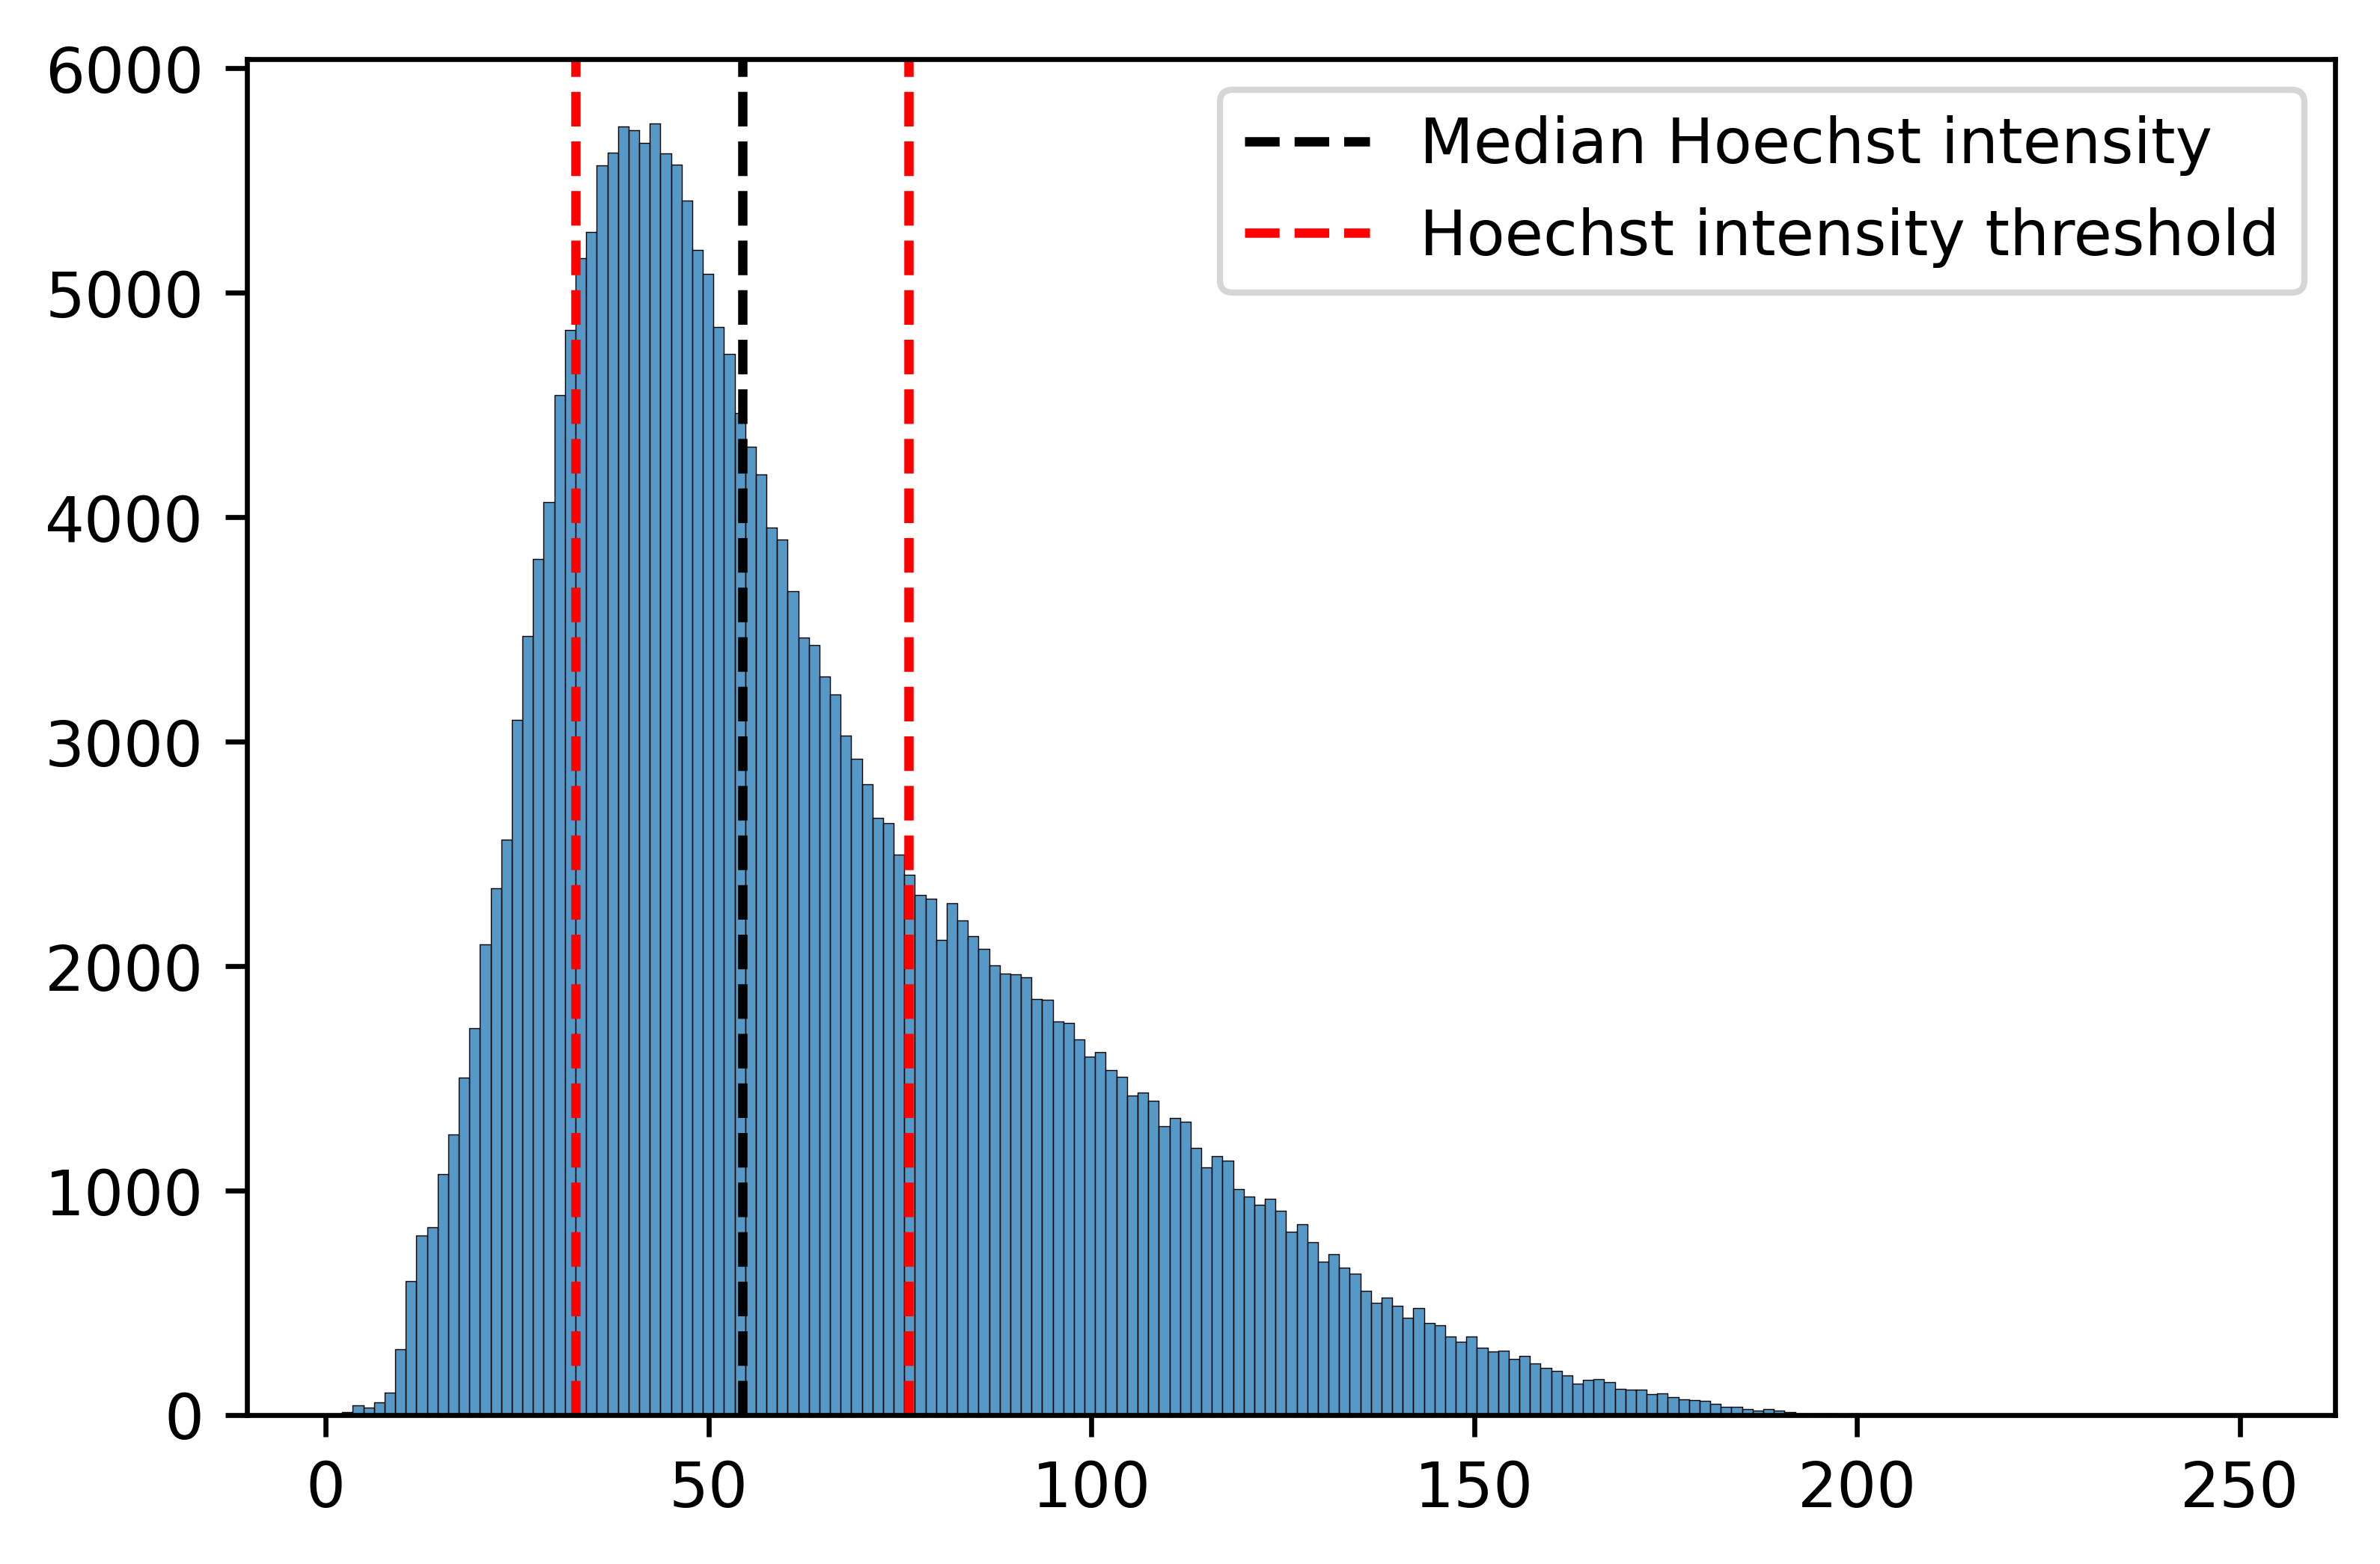

In [9]:
ax = sns.histplot(data=nmco_feats, x="int_mean")
ax.axvline(x=int_median, c="k", linestyle="--", label="Median Hoechst intensity")
ax.axvline(
    x=int_median - 0.5 * int_iqr,
    c="r",
    linestyle="--",
    label="Hoechst intensity threshold",
)
ax.axvline(x=int_median + 0.5 * int_iqr, c="r", linestyle="--")
ax.set_xlabel("")
ax.set_ylabel("")
plt.legend()
plt.show()

---

## 2. StratifiedGrouped K-Fold

We will now go over each individual gene and add a column to the dataframe that indicates to which fold of the respective gene screen the respective nuclei corresponds to. Thereby, we will ensure that all nuclei from the same slide-image are in the same fold to ensure that the model cannot cheat by focussing on imaging artifacts specific to individual slide images.

In [29]:
output_dir = "../../../data/experiments/rohban/images/preprocessing/specific_targets_cv_meanint_thresholded_med05iqr/"
os.makedirs(output_dir, exist_ok=True)

<IPython.core.display.Javascript object>

In [30]:
label_col = "gene_symbol"
group_col = "slide_image_name"
random_state = 1234
n_folds = 4

<IPython.core.display.Javascript object>

In [31]:
target_list = sorted(list(spec_orf_targets) + ["EMPTY"])
print(target_list)
fold_data = get_data_splits_for_label(
    data=md.loc[md.image_file.isin(int_filtered_image_files)],
    label_col=label_col,
    target_list=target_list,
    n_folds=n_folds,
    group_col=group_col,
    random_state=random_state,
)
for k, v in fold_data.items():
    for i in range(len(v)):
        fold_label_data = fold_data[k][i].to_csv(
            os.path.join(output_dir, "nuclei_md_{}_fold_{}.csv".format(k, i))
        )

['AKT1S1', 'ATF4', 'BAX', 'BCL2L11', 'BRAF', 'CASP8', 'CDC42', 'CDKN1A', 'CEBPA', 'CREB1', 'CXXC4', 'DIABLO', 'E2F1', 'ELK1', 'EMPTY', 'ERG', 'FGFR3', 'FOXO1', 'GLI1', 'HRAS', 'IRAK4', 'JUN', 'MAP2K3', 'MAP3K2', 'MAP3K5', 'MAP3K9', 'MAPK7', 'MOS', 'MYD88', 'PIK3R2', 'PRKACA', 'PRKCE', 'RAF1', 'RELB', 'RHOA', 'SMAD4', 'SMO', 'SRC', 'SREBF1', 'TRAF2', 'TSC2', 'WWTR1']
{'MAP3K9': 1182, 'EMPTY': 5864, 'BRAF': 4585, 'MOS': 3316, 'RAF1': 4547, 'GLI1': 1682, 'DIABLO': 1352, 'AKT1S1': 2420, 'PRKACA': 1434, 'MYD88': 2044, 'FOXO1': 2581, 'PRKCE': 5864, 'SMO': 2533, 'CDC42': 3530, 'RHOA': 2913, 'SREBF1': 1539, 'MAP3K5': 1023, 'BAX': 1420, 'ATF4': 2482, 'TSC2': 1285, 'IRAK4': 1214, 'MAP3K2': 2125, 'CDKN1A': 482, 'ELK1': 959, 'HRAS': 749, 'FGFR3': 1682, 'SRC': 1431, 'E2F1': 2298, 'CASP8': 282, 'ERG': 2112, 'JUN': 3015, 'PIK3R2': 1421, 'CEBPA': 2356, 'RELB': 1871, 'TRAF2': 1416, 'BCL2L11': 410, 'MAPK7': 1351, 'CXXC4': 914, 'MAP2K3': 1566, 'WWTR1': 2229, 'CREB1': 1328, 'SMAD4': 1103}


<IPython.core.display.Javascript object>

<AxesSubplot:>

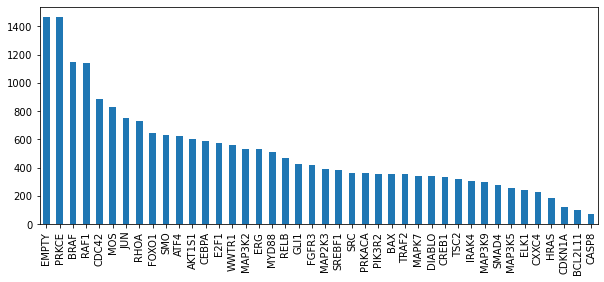

<IPython.core.display.Javascript object>

In [32]:
fold_data["test"][0].gene_symbol.value_counts().plot(kind="bar", figsize=(10, 4))

<AxesSubplot:>

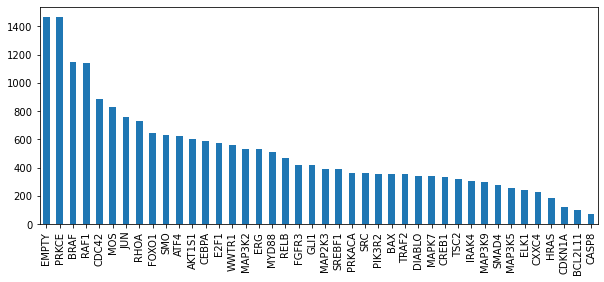

<IPython.core.display.Javascript object>

In [33]:
fold_data["test"][1].gene_symbol.value_counts().plot(kind="bar", figsize=(10, 4))

<AxesSubplot:>

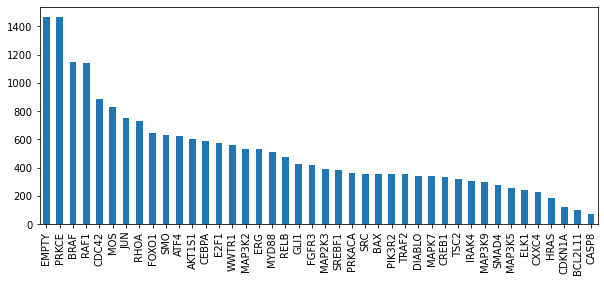

<IPython.core.display.Javascript object>

In [34]:
fold_data["test"][2].gene_symbol.value_counts().plot(kind="bar", figsize=(10, 4))

<AxesSubplot:>

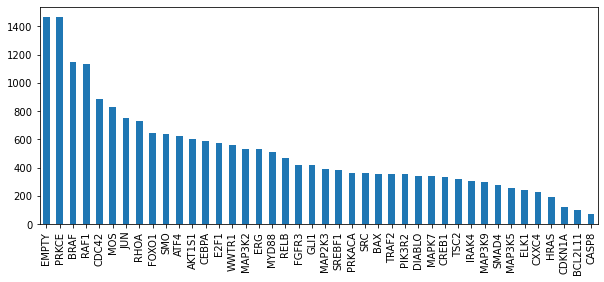

<IPython.core.display.Javascript object>

In [35]:
fold_data["test"][3].gene_symbol.value_counts().plot(kind="bar", figsize=(10, 4))